In [1]:
#coding=UTF-8
import glob
import os
import librosa
import numpy as np
import tensorflow as tf
from sklearn.metrics import precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

#전처리
def get_stream(audio, window_size): # fix the audio daya size up to 3s (512*128frames=65536)
    if audio.shape[0] < window_size:
        padding = np.zeros(window_size-audio.shape[0]) #window size만큼 Zero-Padding
        stream = np.concatenate((audio,padding), axis=0) #audio and padding will be joined
    elif audio.shape[0] >= window_size:
        stream = np.resize(audio,window_size)

    return stream

def windows(data, window_size):
    start = 0
    while start < len(data):
        yield int(start), int(start + window_size)
        start += (window_size / 2)


#특징추출
def extract_features(parent_dir,sub_dirs,file_ext="*.wav",bands = 64, frames = 41): #bands,frames 128
    window_size = 512 * (frames - 1)
    log_specgrams = []
    labels = []
    for l, sub_dir in enumerate(sub_dirs):
        print (sub_dir)
        for fn in glob.glob(os.path.join(parent_dir, sub_dir, file_ext)): #glob.glob를 통해 디렉토리 내 파일 목록을 가져옴
            sound_clip,s = librosa.load(fn) #Read file and get sr, s=sampling rate(sr) of sound_clip
            label = sub_dir
            for (start,end) in windows(sound_clip,window_size):
                if(len(sound_clip[start:end]) == window_size):
                    signal = sound_clip[start:end]
                    melspec = librosa.feature.melspectrogram(signal, n_mels = bands)
                    logspec = librosa.amplitude_to_db(melspec)
                    logspec = logspec.T.flatten()[:, np.newaxis].T
                    log_specgrams.append(logspec)
                    labels.append(label)
                     
    log_specgrams = np.asarray(log_specgrams).reshape(len(log_specgrams),bands,frames,1) #1D
    features = np.concatenate((log_specgrams, np.zeros(np.shape(log_specgrams))), axis = 3) #3D array
    for i in range(len(features)):
        features[i, :, :, 1] = librosa.feature.delta(features[i, :, :, 0])
    return np.array(features), np.array(labels,dtype = np.int)


parent_dir = 'sound_sample'
print("START")
sub_dirs = ['0','1','2','3','4']
'''
0 car
1 dog
2 babycrying
3 siren
4 other(daily)
'''
features, labels = extract_features(parent_dir,sub_dirs)


START
0
1
2
3
4


In [2]:
import collections
collections.Counter(labels) #Window size만큼 나누어 붙인 라벨 당 개수

Counter({0: 918, 1: 1049, 2: 1245, 3: 842, 4: 4467})

In [3]:
print(features.shape) #shape -> 차원 확인, (window sized features, 64 bandwidth, 41 frames, channels)--->왜 channels=2가 나오지????
print(labels.shape)

(8521, 64, 41, 2)
(8521,)


In [4]:
validation_size = 0.20
seed = 42
X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size=validation_size, random_state=seed)
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(6816, 64, 41, 2)
(6816,)
(1705, 64, 41, 2)
(1705,)


In [5]:
from keras import models
from keras import layers
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPool2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics 

# Construct model 
#model =models.Sequential(), 모델 초기화
model =models.Sequential()
# model2 = models.Sequential()

# model
#Conv2D(filters, kernel, rectifier, (cols,rows,channels))
model.add(layers.Conv2D(24, (4, 4), activation='relu', input_shape=(64, 41, 2))) #bands,frames 128
#model.add(layers.MaxPooling2D((4, 2)))
model.add(layers.Dropout(0.5)) #Overfitting을 방지하기 위해 입력값의 50%를 0으로 만듬/weight=0.5

model.add(layers.Conv2D(48, (4, 4), activation='relu'))
#model.add(layers.MaxPooling2D((4, 2)))
model.add(layers.Dropout(0.5))

model.add(layers.Conv2D(48, (4, 4), activation='relu'))

# model 2
# model2.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(60, 41, 2)))
# model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model2.add(layers.MaxPooling2D((2, 2)))
# model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
#model.add(layers.Dense(64, activation='relu'))
#입력층 생성 Dense(units = num of output neuron), 튜닝 방법: input layer의 node와 output layer의 노드의 평균
model.add(layers.Dense(32, input_dim = 64, activation='relu')) #X_train.shape[1]
model.add(layers.Dense(5, activation='softmax')) #출력층 생성 Class가 5이므로 units = 5

model.summary()
# model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 61, 38, 24)        792       
_________________________________________________________________
dropout_1 (Dropout)          (None, 61, 38, 24)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 58, 35, 48)        18480     
_________________________________________________________________
dropout_2 (Dropout)          (None, 58, 35, 48)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 55, 32, 48)        36912     
_________________________________________________________________
flatten_1 (Flatten)          (None, 84480)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)               

Using TensorFlow backend.


In [6]:
# model 1
#start = datetime.now()

#Classification
#Categrical_crossentropy -> multi-class classification
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#duration = datetime.now() - start
#print("Model compilation completed in time: ", duration)

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 61, 38, 24)        792       
_________________________________________________________________
dropout_1 (Dropout)          (None, 61, 38, 24)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 58, 35, 48)        18480     
_________________________________________________________________
dropout_2 (Dropout)          (None, 58, 35, 48)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 55, 32, 48)        36912     
_________________________________________________________________
flatten_1 (Flatten)          (None, 84480)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)               

In [7]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

#set early stopping criteria
pat = 10 #this is the number of epochs with no improvment after which the training will stop
early_stopping = EarlyStopping(monitor='val_loss', patience=pat, verbose=1) # patience -> 성능이 증가 되지 않는 epoch를 몇 번 진행할지 / verbose=1 -> 언제 트레이닝을 멈췄는지 출력

#define the model checkpoint callback -> this will keep on saving the best model with validation performance as a physical file
model_checkpoint = ModelCheckpoint('hwayeon_Cnn+3fold_sound_sample.h5', verbose=1, save_best_only=True)

#define a function to fit the model
def fit_and_evaluate(t_x, val_x, t_y, val_y, EPOCHS=50, BATCH_SIZE=64):
    results = model.fit(t_x, t_y, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[early_stopping, model_checkpoint], 
              verbose=1, validation_split=0.2)  
    print("Val Score: ", model.evaluate(val_x, val_y))
    return results

In [8]:
n_folds=3
epochs=50
batch_size=64 # 128samples train 후 정답 확인

#save the model history in a list after fitting so that we can plot later
model_history = [] 

for i in range(n_folds):
    print("Training on Fold: ",i+1)
    t_x, val_x, t_y, val_y = train_test_split(features, labels, test_size=0.2, random_state = np.random.randint(1,1000, 1)[0])
    model_history.append(fit_and_evaluate(t_x, val_x, t_y, val_y, epochs, batch_size))
    print("======="*12, end="\n\n\n")

Training on Fold:  1
Train on 5452 samples, validate on 1364 samples
Epoch 1/50
5452/5452 [==============================] - 27s 5ms/step - loss: 7.5411 - accuracy: 0.4932 - val_loss: 1.3669 - val_accuracy: 0.5198

Epoch 00001: val_loss improved from inf to 1.36690, saving model to hwayeon_Cnn+3fold_sound_sample.h5
Epoch 2/50
5452/5452 [==============================] - 27s 5ms/step - loss: 0.8531 - accuracy: 0.6812 - val_loss: 0.6123 - val_accuracy: 0.7999

Epoch 00002: val_loss improved from 1.36690 to 0.61234, saving model to hwayeon_Cnn+3fold_sound_sample.h5
Epoch 3/50
5452/5452 [==============================] - 27s 5ms/step - loss: 0.5773 - accuracy: 0.8072 - val_loss: 0.5386 - val_accuracy: 0.8174

Epoch 00003: val_loss improved from 0.61234 to 0.53863, saving model to hwayeon_Cnn+3fold_sound_sample.h5
Epoch 4/50
5452/5452 [==============================] - 27s 5ms/step - loss: 0.4752 - accuracy: 0.8417 - val_loss: 0.4106 - val_accuracy: 0.8666

Epoch 00004: val_loss improved fr

1705/1705 [==============================] - 1s 813us/step
Val Score:  [0.28457483483199847, 0.9255132079124451]


Training on Fold:  3
Train on 5452 samples, validate on 1364 samples
Epoch 1/50
5452/5452 [==============================] - 27s 5ms/step - loss: 0.1680 - accuracy: 0.9485 - val_loss: 0.1607 - val_accuracy: 0.9435

Epoch 00001: val_loss did not improve from 0.15080
Epoch 2/50
5452/5452 [==============================] - 27s 5ms/step - loss: 0.1352 - accuracy: 0.9580 - val_loss: 0.1693 - val_accuracy: 0.9443

Epoch 00002: val_loss did not improve from 0.15080
Epoch 3/50
5452/5452 [==============================] - 27s 5ms/step - loss: 0.0981 - accuracy: 0.9657 - val_loss: 0.1402 - val_accuracy: 0.9567

Epoch 00003: val_loss improved from 0.15080 to 0.14025, saving model to hwayeon_Cnn+3fold_sound_sample.h5
Epoch 4/50
5452/5452 [==============================] - 27s 5ms/step - loss: 0.0963 - accuracy: 0.9644 - val_loss: 0.1712 - val_accuracy: 0.9421

Epoch 00004: val_loss di

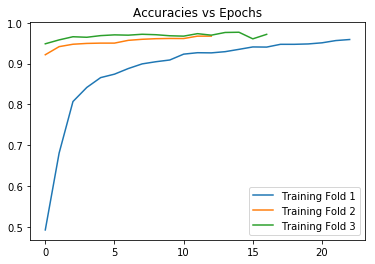

In [14]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram

plt.title('Accuracies vs Epochs')
plt.plot(model_history[0].history['accuracy'], label='Training Fold 1')
plt.plot(model_history[1].history['accuracy'], label='Training Fold 2')
plt.plot(model_history[2].history['accuracy'], label='Training Fold 3')
plt.legend()
plt.show()

In [10]:
from keras.models import load_model
#Load the model that was saved by ModelCheckpoint
model = load_model('hwayeon_Cnn+3fold_sound_sample.h5')

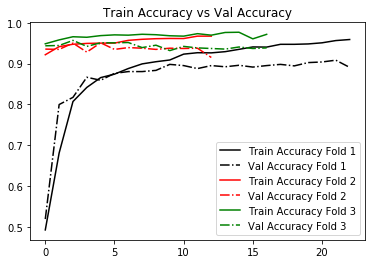

In [11]:
plt.title('Train Accuracy vs Val Accuracy')
plt.plot(model_history[0].history['accuracy'], label='Train Accuracy Fold 1', color='black')
plt.plot(model_history[0].history['val_accuracy'], label='Val Accuracy Fold 1', color='black', linestyle = "dashdot")
plt.plot(model_history[1].history['accuracy'], label='Train Accuracy Fold 2', color='red', )
plt.plot(model_history[1].history['val_accuracy'], label='Val Accuracy Fold 2', color='red', linestyle = "dashdot")
plt.plot(model_history[2].history['accuracy'], label='Train Accuracy Fold 3', color='green', )
plt.plot(model_history[2].history['val_accuracy'], label='Val Accuracy Fold 3', color='green', linestyle = "dashdot")
plt.legend()
plt.show()

In [12]:
#Load the model that was saved by ModelCheckpoint
model = load_model('hwayeon_Cnn+3fold_sound_sample.h5')

In [13]:
model.evaluate(X_test, Y_test)

1705/1705 [==============================] - 1s 843us/step


[0.09595638415789849, 0.9665688872337341]